# Simulating a model with GINsim and MaBoSS

### Simulations and analyses of a model of cell cycle

Docker and Python need to be pre-installed, then type in a terminal:
```
mkdir notebooks
colomoto-docker -V 2020-08-01 --bind
```

This notebook can be launched using the Docker image of CoLoMoTo:
```
   $docker pull colomoto/colomoto-docker:2018-03-31
```

or by creating a conda environment with the following command:

```
    $conda install -c potassco -c conda-forge -c colomoto pypint pymaboss
    $conda create -n myenv -c colomoto ginsim-python pymaboss -c potassco seaborn
```

To launch this notebook, type the command:
```
    jupyter notebook
```

In [1]:
# Set up working environment for CoLoMoTo
%matplotlib inline
import numpy as np
#import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import ginsim
import biolqm
import maboss

from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
import pandas as pd # for the visualization of lists of states

This notebook has been executed using the docker image `colomoto/colomoto-docker:2023-04-01`

## Import model from Cell Collective

The model can be imported directly from Cell Collective collection of models

In [2]:
model_biolqm = biolqm.load("cellcollective-2396-1.sbml")
#model_biolqm = biolqm.load("https://cellcollective.org/#module/2396:1/mammalian-cell-cycle-2006/1")

In [3]:
## Compute fixpoints
fps = biolqm.fixpoints(model_biolqm)
print(len(fps), "fixpoints") # shows the number of fixpoints
tabulate(fps) # table displaying all the fixpoints

1 fixpoints


,S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9,S_10
0,0,0,0,0,1,0,1,0,1,0


In [4]:
# Compute trapspaces
%time traps = biolqm.trapspaces(model_biolqm)
print(len(traps), "trapspaces") # shows the number of trapspaces
tabulate(traps) # table displaying all the trapspaces

CPU times: user 19.1 ms, sys: 3.25 ms, total: 22.4 ms
Wall time: 251 ms
2 trapspaces


,S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9,S_10
0,0,0,0,0,1,0,1,0,1,0
1,254,254,254,254,0,254,254,1,0,254


An alternative is to load the model in GINsim directly and use biolqm to visualize the stable states

## Load GINsim model 

In [5]:
model_ginsim = ginsim.load("boolean_cell_cycle.zginml")
ginsim.show(model_ginsim)

In [6]:
## Use biolqm to visualize the stable states
model_biolqm = ginsim.to_biolqm(model_ginsim) # convert to biolqm

## Compute fixpoints
fps = biolqm.fixpoints(model_biolqm)
print(len(fps), "fixpoints") # shows the number of fixpoints
pd.DataFrame(fps)
#tabulate(fps) # table displaying all the fixpoints

AttributeError: module 'biolqm' has no attribute 'fixpoints'

## MaBoSS simulation of the wild type model

Run MaBoSS now. 

In [7]:
model_maboss = biolqm.to_maboss(model_biolqm) # convert to maboss
model_maboss.update_parameters(sample_count=10000,max_time=30, time_tick=0.1)

Load the model with either all 0s (WT_allinputs) or random initial conditions (model_maboss_random) and modify some configuration parameters. Note that if you used the export of GINsim export, all the initial values will be set to 0

### Intial conditions: All inputs are 0

In [8]:
## Load the Wild-Type model
#WT = maboss.load(bnd_file, cfg_file)

WT_allinputs = model_maboss.copy()

In [9]:
## Select outputs for visualisation of the results
WT_allinputs.network.set_output(('CycD','CycE','CycB'))

Text(0.5, 1.0, 'WT pie chart')

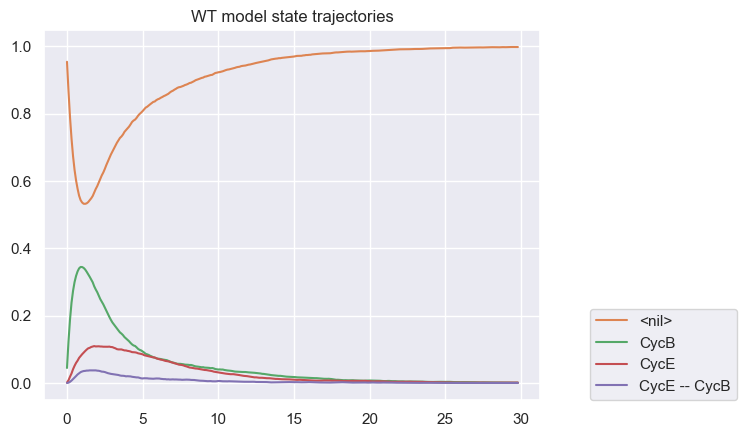

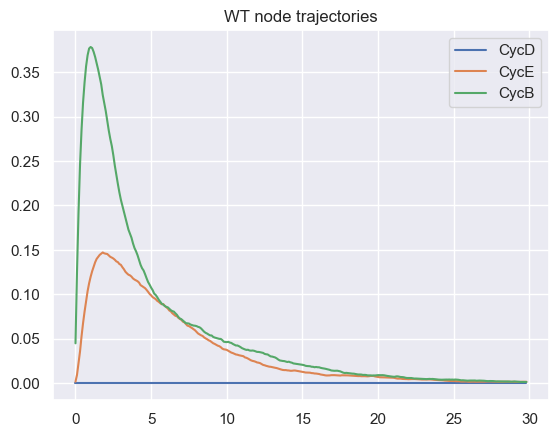

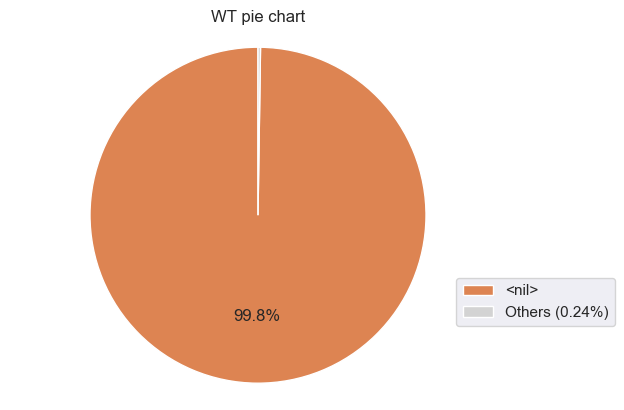

In [10]:
## Run a MaBoSS simulation
run_WT_allinputs = WT_allinputs.run()

## Plot the results of the WT simulation
run_WT_allinputs.plot_trajectory(legend=True)
plt.title('WT model state trajectories')

run_WT_allinputs.get_nodes_probtraj().plot(legend=True)
plt.title('WT node trajectories')
## Note that the model state <nil> means that none of the external variables are ON. It corresponds here to the phenotype Homeostatic State (HS)

# Plot pie chart
run_WT_allinputs.plot_piechart()
plt.title('WT pie chart')

## You may want to save the figure
# figure = run_WT_allinputs.get_states_probtraj().plot()
# save_figure(figure, 'WT')

With MaBoSS, we can quantify the probability to reach a steady state or a solution

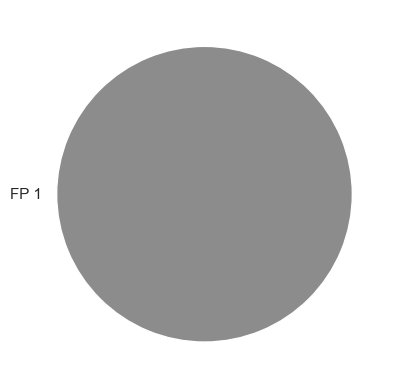

In [11]:
run_WT_allinputs.plot_fixpoint()

### Intial conditions: All inputs are random

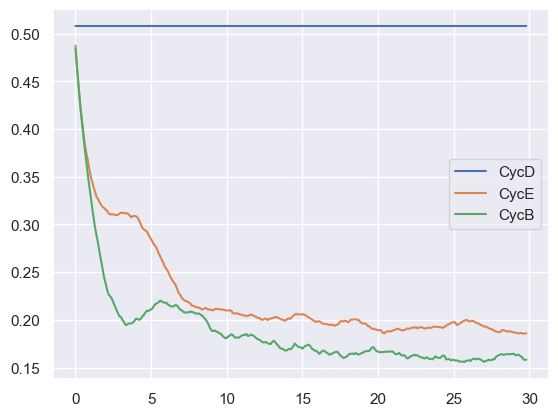

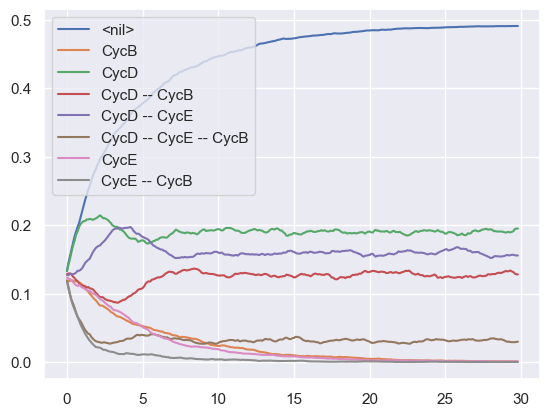

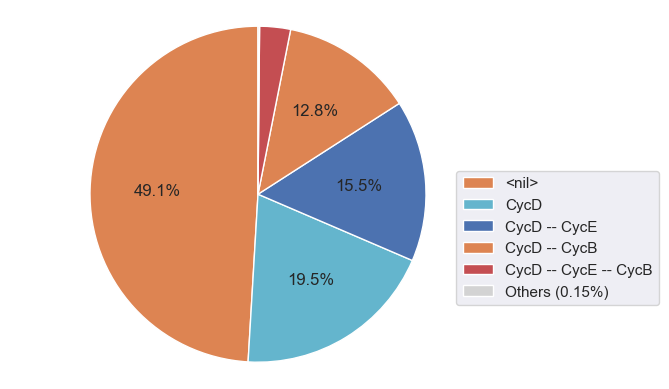

In [13]:
model_maboss_random = model_maboss.copy()

for n in model_maboss_random.network:
    model_maboss_random.network.set_istate(n,[0.5,0.5])

model_maboss_random.network.set_output(('CycD','CycE','CycB'))
    
run_model_maboss_random = model_maboss_random.run()

## Visualize the results

## Trajectories of node probabilities
run_model_maboss_random.get_nodes_probtraj().plot(legend=True)

## Trajectories of model states
run_model_maboss_random.get_states_probtraj().plot(legend=True)

## As a pie chart
run_model_maboss_random.plot_piechart()

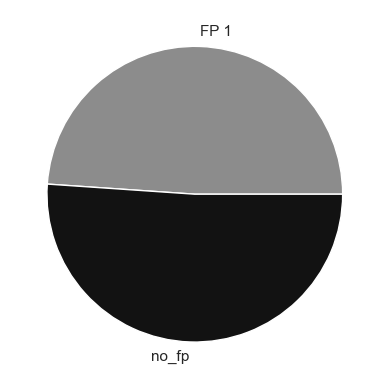

In [14]:
run_model_maboss_random.plot_fixpoint()

### Initial conditions: Entry into the cell cycle

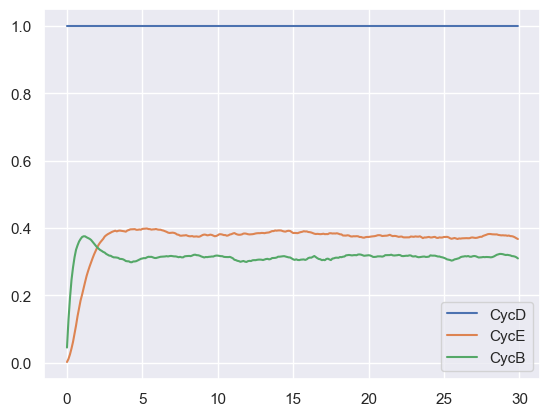

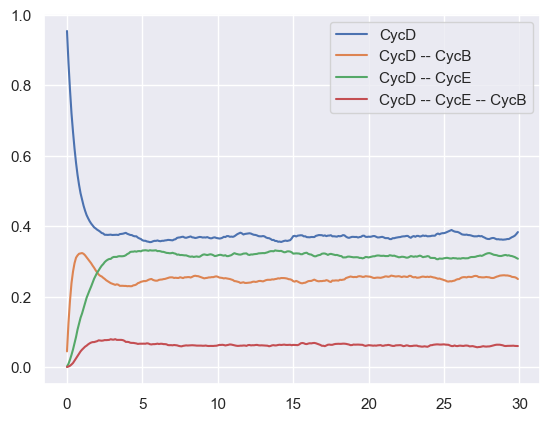

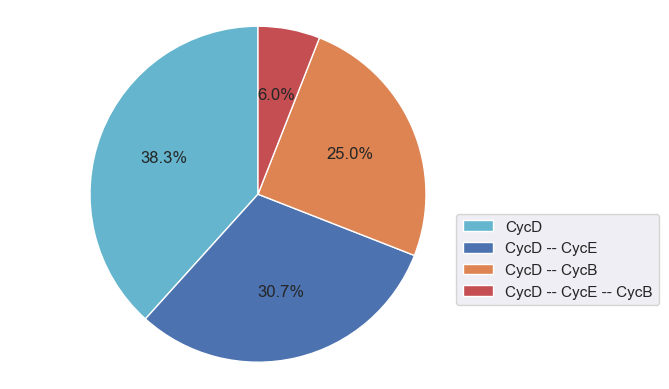

In [15]:
cond1 = model_maboss.copy()

## To test combinations of inputs, include all lines
cond1.network.set_istate('CycD', [0,1])

cond1.network.set_output(('CycD','CycE','CycB'))

## Visualize only the selected phenotypes
run_cond1 = cond1.run()
## Plot the trajectories
run_cond1.get_nodes_probtraj().plot(legend=True)
run_cond1.get_states_probtraj().plot(legend=True)

## Plot pie chart
run_cond1.plot_piechart()

## Mutant analysis

### CDC20 mutant

Text(0.5, 1.0, 'Cdc20 mutant')

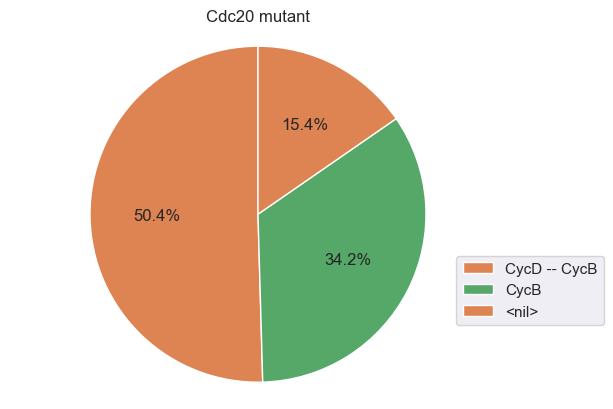

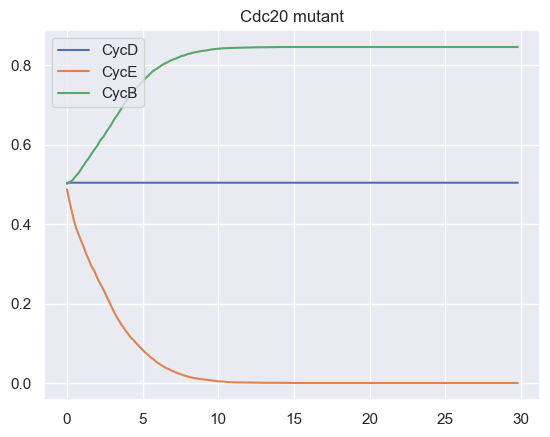

In [16]:
## Loss of function for p53 loss of function
mut_CDC20_OFF = model_maboss_random.copy()
#mut_p53_OFF.update_parameters(max_time=150, time_tick=0.5)
mut_CDC20_OFF.mutate("Cdc20", "OFF")
mutres_CDC20_OFF = mut_CDC20_OFF.run()
mutres_CDC20_OFF.plot_piechart()
plt.title('Cdc20 mutant')
mutres_CDC20_OFF.get_nodes_probtraj().plot(legend=True)
plt.title('Cdc20 mutant')